# Image Classification using AWS Sagemaker.

### Project Overview:

The primary goal of this project is not just to achieve high accuracy in identifying dog breeds from images but to showcase the best practices of Machine Learning engineering. I will leverage AWS SageMaker to fine-tune a pre-trained model, using SageMaker's debugging and profiling tools, and finally deploy our trained model to an endpoint.

**Dataset:** The dataset chosen for this project is the "Dog Breed Classification" dataset, which comprises images from 133 different dog breeds. These images are neatly divided into training, testing, and validation sets.

In [2]:
!pip install smdebug > /dev/null 2>&1

In [15]:
import pandas as pd
import IPython
import requests
import os
from PIL import Image
import io
import smdebug
import numpy as np

import sagemaker
from sagemaker.predictor import Predictor


from sagemaker.tuner import ContinuousParameter, CategoricalParameter, IntegerParameter, HyperparameterTuner
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner
from sagemaker import get_execution_role
from smdebug.core.modes import ModeKeys
from smdebug import modes
from smdebug.trials import create_trial
from sagemaker.pytorch import PyTorchModel
import torchvision.transforms as T



import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import boto3

In [4]:
role = sagemaker.get_execution_role()
session = boto3.session.Session()
region = session.region_name
bucket = "project-3-aws-ml-udacity"

print(f"Role: {role}")
print(f"Session: {session}")
print(f"Region: {region}")
print(f"Bucket: {bucket}")

Role: arn:aws:iam::064258437334:role/service-role/AmazonSageMaker-ExecutionRole-20230908T222471
Session: Session(region_name='us-east-2')
Region: us-east-2
Bucket: project-3-aws-ml-udacity


## Dataset Loading

In [5]:
# Upload the data to the S3 Bucket and Sagemaker
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip > /dev/null 2>&1
!unzip dogImages.zip > /dev/null 2>&1
!aws s3 cp dogImages s3://project-3-aws-ml-udacity/dogsImages/ --recursive > /dev/null 2>&1

print("----------Data Uploaded----------")

----------Data Uploaded----------


### Environment varibles

In [5]:
data = f"s3://{bucket}/dogImages/"
output = f"s3://{bucket}/output/"
model_dir = f"s3://{bucket}/model/"

os.environ["S3_BUCKET"] = bucket
os.environ['SM_CHANNEL_TRAIN']= data 
os.environ['SM_OUTPUT_DATA_DIR']= output
os.environ['SM_MODEL_DIR']= model_dir

print(data)
print(output)
print(model_dir)

s3://project-3-aws-ml-udacity/dogImages/
s3://project-3-aws-ml-udacity/output/
s3://project-3-aws-ml-udacity/model/


### Dataset exploration

This dataset is organized into three categories: train, test, and valid, each holding subdirectories for individual breeds.

Now, let's display some data exploration so we can proceed with machine learning tasks more effectively:

In [6]:
base_path = "dogImages"
folders = ["test", "train", "valid"]

all_breeds = []
image_counts = {}

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    
    breeds = os.listdir(folder_path)
    
    all_breeds.extend(breeds)
    
    for breed in breeds:
        breed_path = os.path.join(folder_path, breed)
        
        num_images = len([f for f in os.listdir(breed_path) if os.path.isfile(os.path.join(breed_path, f))])
        
        image_counts[breed] = image_counts.get(breed, 0) + num_images

unique_breeds = set(all_breeds)

# Mostramos resultados
print(f"Total breeds: {len(unique_breeds)}")
print(f"Breeds: {unique_breeds}")
print("Number of pictures per Breed:")
for breed, count in image_counts.items():
    print(f"{breed}: {count} images")

Total breeds: 133
Breeds: {'122.Pointer', '017.Bearded_collie', '121.Plott', '040.Bulldog', '084.Icelandic_sheepdog', '033.Bouvier_des_flandres', '049.Chinese_crested', '124.Poodle', '080.Greater_swiss_mountain_dog', '130.Welsh_springer_spaniel', '023.Bernese_mountain_dog', '110.Norwegian_lundehund', '109.Norwegian_elkhound', '026.Black_russian_terrier', '103.Mastiff', '018.Beauceron', '045.Cardigan_welsh_corgi', '066.Field_spaniel', '052.Clumber_spaniel', '132.Xoloitzcuintli', '024.Bichon_frise', '078.Great_dane', '039.Bull_terrier', '035.Boykin_spaniel', '114.Otterhound', '051.Chow_chow', '002.Afghan_hound', '079.Great_pyrenees', '123.Pomeranian', '068.Flat-coated_retriever', '014.Basenji', '098.Leonberger', '058.Dandie_dinmont_terrier', '016.Beagle', '001.Affenpinscher', '042.Cairn_terrier', '073.German_wirehaired_pointer', '057.Dalmatian', '093.Kerry_blue_terrier', '067.Finnish_spitz', '128.Smooth_fox_terrier', '133.Yorkshire_terrier', '043.Canaan_dog', '099.Lhasa_apso', '034.Boxer

Our dataset contains 133 dog breeds

#  -------------------------------------------------------------------------------------------------------------
#  -------------------------------------------------------------------------------------------------------------

## Hyperparameter Tuning

In [6]:
# Hyperparameters ranges

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([1, 2])
}
print("Hyperparameter ranges set.")


# Objective metric and type for the hyperparameter tuning.
objective_metric_name = "average test loss"
objective_type = "Minimize"


metric_definitions = [{"Name": "AVG Test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]
print("Objective metric and regex pattern defined.")

Hyperparameter ranges set.
Objective metric and regex pattern defined.


In [7]:
# Creating the PyTorch estimator with necessary configurations.

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c5.2xlarge"
)

print("PyTorch estimator created")


# Initializing the hyperparameter tuner with the previously defined settings.
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type,
)
print("Hyperparameter tuner initialized")

PyTorch estimator created
Hyperparameter tuner initialized


In [51]:
# Hyperparameter tune

tuner.fit({'data': "s3://project-3-aws-ml-udacity/dogsImages"})

print("Hyperparameter tuning completed!")

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
...................................................................................................................................................................................................................................................................................................!
Hyperparameter tuning completed!


In [54]:
# Best hypermarameters of the bes trained model
best_estimator = tuner.best_estimator()
best_hyperparameters = best_estimator.hyperparameters()
print(f"---------------Best Hyperparameters---------------")
best_hyperparameters


2023-09-17 01:01:38 Starting - Preparing the instances for training
2023-09-17 01:01:38 Downloading - Downloading input data
2023-09-17 01:01:38 Training - Training image download completed. Training in progress.
2023-09-17 01:01:38 Uploading - Uploading generated training model
2023-09-17 01:01:38 Completed - Resource released due to keep alive period expiry
---------------Best Hyperparameters---------------


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'epochs': '"2"',
 'lr': '0.0010152583471663874',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-09-17-00-40-38-301"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-064258437334/pytorch-training-2023-09-17-00-40-38-301/source/sourcedir.tar.gz"'}

#### OUPUT Best Hyperparameters

- '_tuning_objective_metric': '"average test loss"',
- 'batch-size': '"64"',
- 'epochs': '"2"',
- 'lr': '0.0010152583471663874',
- 'sagemaker_container_log_level': '20',
- 'sagemaker_estimator_class_name': '"PyTorch"',
- 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
- 'sagemaker_job_name': '"pytorch-training-2023-09-17-00-40-38-301"',
- 'sagemaker_program': '"hpo.py"',
- 'sagemaker_region': '"us-east-2"',
- 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-064258437334/pytorch-training-2023-09-17-00-40-38-301/source/sourcedir.tar.gz"'}

The optimal training job, named <code>pytorch-training-2023-09-17-00-40-38-301</code>, was found using the SageMaker's PyTorch estimator. It achieved the best performance with the following hyperparameters:

- Learning Rate: 0.0010152583471663874
- Batch Size: 64
- Epochs: 2

## Model Profiling and Debugging

Now we will create and finetune a new model using the best hyperparameters. Our <code>train_model.py</code> applies model profiling and debugging.

First of all, we will create a dictionary with the best parameters:

In [11]:
# Hyperparameters dictionary
hyperparameters = {
    "batch-size": '64',
    "lr": '0.0010152583471663874',
    "epochs": '2'
}

hyperparameters

{'batch-size': '64', 'lr': '0.0010152583471663874', 'epochs': '2'}

In [12]:
# Profiling rules and hooks for profiling

rules = [ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

In [18]:
# Configuration for the model profiler
profiling_configuration = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile()
)

# List of configurations for collecting data during debugging
debugging_collections = [
    CollectionConfig(
        name="model_weights",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="model_gradients",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases_values",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="LossOutput", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

# Debugger configuration setup
debug_setup_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
    collection_configs=debugging_collections
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [19]:
# Creating and fitting our estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="Debugging-Image-Classification",
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    rules=rules,
    debugger_hook_config=debug_setup_config,  
    profiler_config=profiling_configuration
)

In [20]:
# fitting the estimator
estimator.fit({'data': "s3://project-3-aws-ml-udacity/dogsImages"})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Debugging-Image-Classification-2023-09-17-11-28-25-671


Using provided s3_resource
2023-09-17 11:28:26 Starting - Starting the training job...
2023-09-17 11:28:49 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
...
2023-09-17 11:29:26 Downloading - Downloading input data...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-17 11:31:02,700 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-17 11:31:02,703 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-17 11:31:02,711 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-17 11:31:02,713 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-09-17 11:31:02,866 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-17 11:31:02,880 sagemaker-training-toolkit INFO     No 

In [30]:
# Load estimator
job_name = estimator.latest_training_job.name
estimator = sagemaker.pytorch.PyTorch.attach(job_name)


2023-09-17 11:50:16 Starting - Preparing the instances for training
2023-09-17 11:50:16 Downloading - Downloading input data
2023-09-17 11:50:16 Training - Training image download completed. Training in progress.
2023-09-17 11:50:16 Uploading - Uploading generated training model
2023-09-17 11:50:16 Completed - Training job completed


In [31]:
# Description of training job
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

description

{'TrainingJobName': 'Debugging-Image-Classification-2023-09-17-11-28-25-671',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:064258437334:training-job/Debugging-Image-Classification-2023-09-17-11-28-25-671',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '"64"',
  'epochs': '"2"',
  'lr': '"0.0010152583471663874"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"Debugging-Image-Classification-2023-09-17-11-28-25-671"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-2"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-training:1

### Debugging Output

In [40]:
trial = create_trial("s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/debug-output/")

[2023-09-17 12:16:17.066 pytorch-2-0-0-cpu-py3-ml-t3-medium-091a6a8519e36ff65ac97f05f4a4:20 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/debug-output/


In [41]:
print(trial.tensor_names())

[2023-09-17 12:17:58.503 pytorch-2-0-0-cpu-py3-ml-t3-medium-091a6a8519e36ff65ac97f05f4a4:20 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-09-17 12:17:59.523 pytorch-2-0-0-cpu-py3-ml-t3-medium-091a6a8519e36ff65ac97f05f4a4:20 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'ResNet_bn1.bias', 'ResNet_bn1.weight', 'ResNet_conv1.weight', 'ResNet_fc.bias', 'ResNet_fc.weight', 'ResNet_layer1.0.bn1.bias', 'ResNet_layer1.0.bn1.weight', 'ResNet_layer1.0.bn2.bias', 'ResNet_layer1.0.bn2.weight', 'ResNet_layer1.0.bn3.bias', 'ResNet_layer1.0.bn3.weight', 'ResNet_layer1.0.conv1.weight', 'ResNet_layer1.0.conv2.weight', 'ResNet_layer1.0.conv3.weight', 'ResNet_layer1.0.downsample.0.weight', 'ResNet_layer1.0.downsample.1.bias', 'ResNet_layer1.0.downsample.1.weight', 'ResNet_layer1.1.bn1.bias', 'ResNet_layer1.1.bn1.weight', 'ResNet_layer1.1.bn2.bias', 'ResNet_layer1.1.bn2.weight', 'ResNet_layer1.1.bn3.bias', 'ResNet_layer1.1.bn3.weight', 'ResNet_layer

In [42]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

210
42


In [43]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


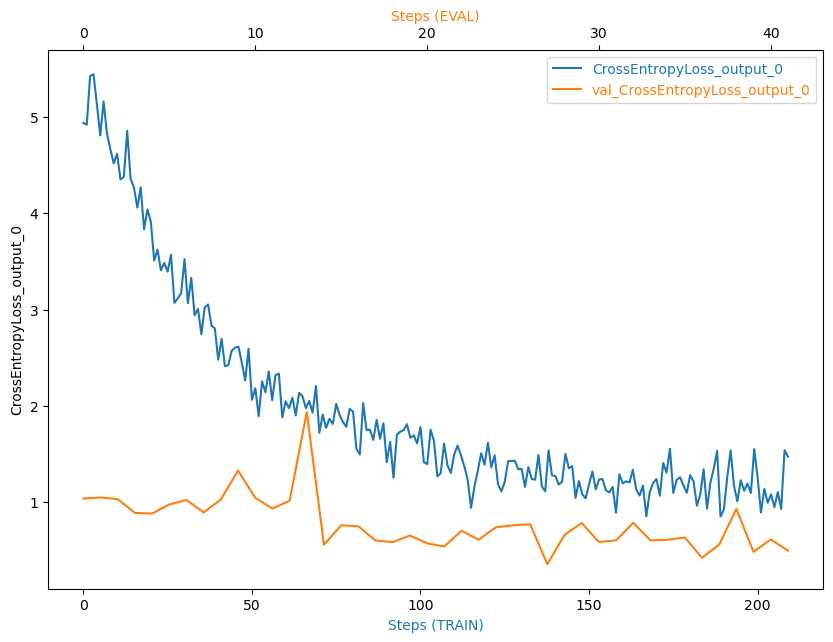

In [44]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**Insights**

- Training loss decline significally from 5 to 1.9, indicating effective learning and fitting to the training data through the steps.
- However, training loss is noisy, suggesting potential improvements with a larger batch size.
- The validation loss starts low and remains relatively steady, hinting at a potential overfitting issue as it's consistently lower than the training loss.


**Improvements**

- Introducing regularization techniques can help mitigate overfitting.
- Augmenting the dataset or acquiring more data might provide a more generalized performance.

In [47]:
# Profiler report

! aws s3 ls s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output --recursive

2023-09-17 11:49:56     376275 Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-09-17 11:49:55     224209 Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-09-17 11:49:51        192 Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-09-17 11:49:51        200 Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-09-17 11:49:51       2320 Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-09-17 11:49:51        127 Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-09-17 11:49:51        199 Debugging-I

In [49]:
! aws s3 cp s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output ./ --recursive

download: s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-2-064258437334/Debugging-Image-

In [53]:
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary() if "Profiler" in rule["RuleConfigurationName"]][0]

In [54]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [7]:
estimator = PyTorch.attach('Debugging-Image-Classification-2023-09-17-11-28-25-671')

model_path = "s3://sagemaker-us-east-2-064258437334/Debugging-Image-Classification-2023-09-17-11-28-25-671/output/model.tar.gz"

pytorch_model = PyTorchModel(
    entry_point="inference.py",
    model_data=model_path, 
    role=role, 
    framework_version="1.8",
    py_version="py36"
)


2023-09-17 11:50:16 Starting - Preparing the instances for training
2023-09-17 11:50:16 Downloading - Downloading input data
2023-09-17 11:50:16 Training - Training image download completed. Training in progress.
2023-09-17 11:50:16 Uploading - Uploading generated training model
2023-09-17 11:50:16 Completed - Training job completed


In [8]:
# Deploying our model to an endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

-----!

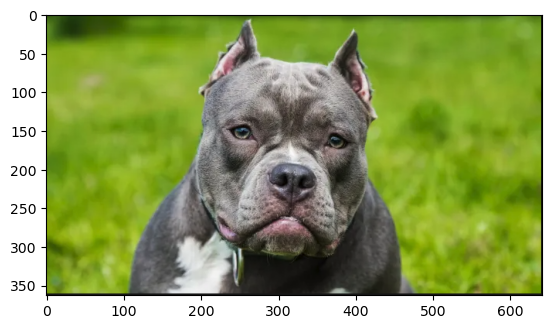

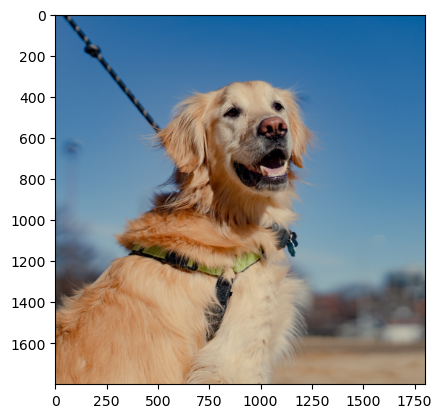

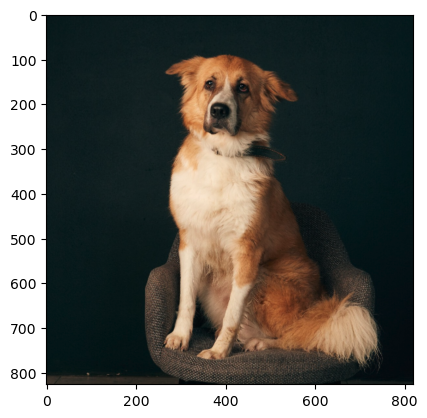

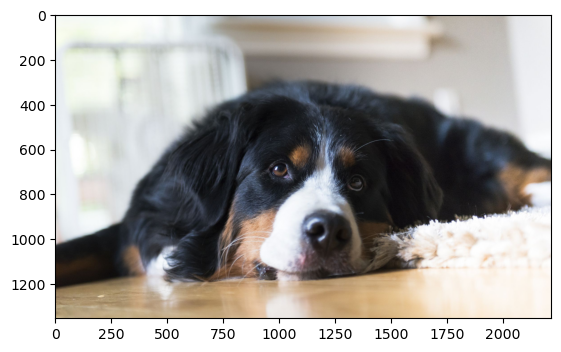

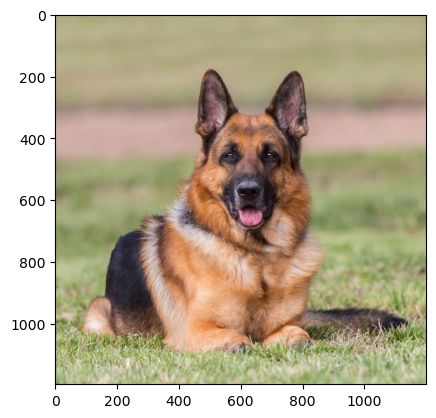

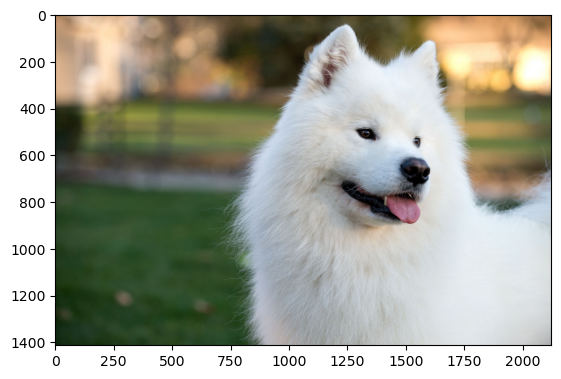

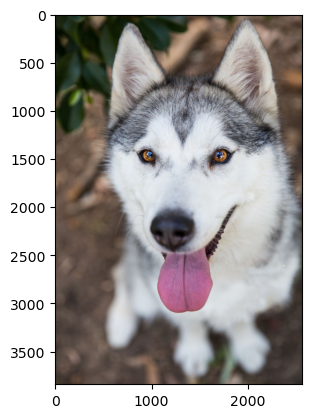

In [9]:
# Path to the pictures of dogs (4 pictures)
directory_path = './test-photos-of-dogs/'
image_paths = [os.path.join(directory_path, img) for img in os.listdir(directory_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

for img in image_paths:
    
    dog = plt.imread(img)
    plt.imshow(dog)
    plt.show()

[[ -9.19241905 -11.05782604 -10.4797678   -5.49319315  -8.32229996
   -9.2524538   -8.96589947   2.94972849  -8.29799843 -10.11236095
   -7.51197672 -10.80042839  -9.71258545  -7.30810499  -6.78236198
   -7.78302193  -8.19334698  -7.83795738  -8.75832939  -9.28977203
  -10.51194477 -15.46781826 -12.05225563  -8.28513622  -6.70008373
   -8.16781616  -9.5361414   -7.25427914 -10.64596844  -8.72292328
  -12.91409969  -0.92428362  -6.39305687  -3.53052449  -9.12622356
  -11.4674139  -11.6920166   -8.56875896  -1.46549714  -2.40568376
   -3.58535743  -7.78682041  -5.72615862   3.93925047 -10.07279682
  -10.55859375  -7.68800402  -4.93076277  -6.29433203  -2.23723626
   -8.99844742  -8.33216095 -10.41847324 -11.16516304  -9.20704079
   -9.20724869  -7.02371073  -8.19412422  -3.9497714   -3.91977692
  -10.12273407  -8.02981377  -7.15779448 -10.70849323  -7.83924198
   -6.47202635 -10.81416702 -10.05702686  -3.14906859  -6.15539455
   -9.16223431  -7.41922283  -7.98491573  -5.82926226  -7.0492

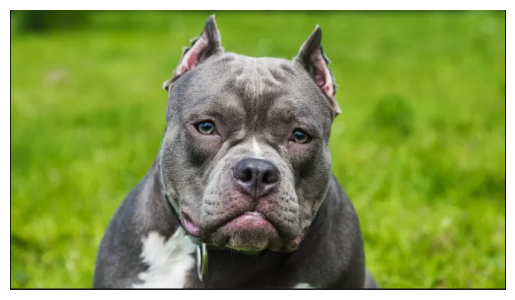

[[-10.10566235  -4.86247969 -10.13318729  -7.75965738  -7.76256514
   -9.1799736   -8.79179955 -10.63245487  -7.68535805  -8.37942696
   -8.87949085  -6.89402437 -10.65778255 -12.45922947  -9.82486916
   -8.36878681 -11.34964371  -9.83807755 -10.83812523 -12.08183861
  -10.88311481 -13.48961353  -7.93565178  -9.92463779 -10.50074005
   -8.39731121 -11.4003191   -8.86815262 -10.68302822  -8.74165344
   -6.43703461 -11.02690506 -13.63642788 -10.80716038  -6.71882629
  -10.89697742  -5.99840212  -7.50531483  -9.06295967 -10.11446667
   -9.95050812 -10.51900387  -7.05159283  -9.48524761 -10.18158817
   -5.84159803  -9.70749855  -6.48756933  -6.98426151  -9.98320484
  -10.49087715  -7.33939362  -7.39337063  -9.7517767   -7.81387758
   -6.12830114  -7.95438242  -8.35233021  -9.17117023  -9.13320446
   -6.45723343  -1.92877543  -7.60717535  -7.85603905  -7.93456364
   -7.43160725  -8.78739452  -4.76730108 -13.51609612  -8.09361076
   -8.6391468   -9.45026112  -8.19327545  -9.55802727 -10.5001

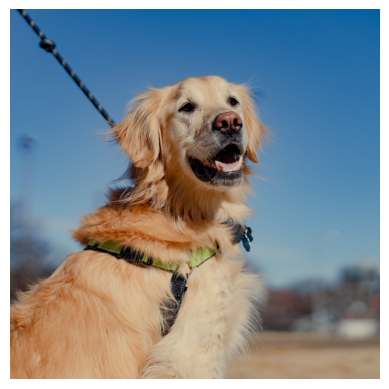

[[ -9.60250664  -7.90931129 -10.25983906  -3.14653325  -5.07877731
   -6.82702351  -5.33309317  -8.04607868  -9.42501736  -5.12307882
   -6.97202444  -3.39361382  -9.52842522  -8.82089329  -8.10690117
   -5.19053221  -9.66302586  -8.62181664  -9.77402306  -9.33107185
   -9.60653687  -9.0086689   -6.77030039  -9.66534901  -9.99281693
  -10.12265873  -9.00552654  -8.37849331  -5.70372152  -7.54059029
   -6.66337442  -7.39796305 -11.36647415  -8.09279728  -9.58508396
   -9.31651306  -6.47357559  -5.97505713  -7.26885653  -7.2929225
   -8.61767864  -9.31042576  -4.25368357  -9.02984142  -4.39047003
   -5.737535    -8.10544109  -4.99300146  -7.77753496  -8.16409492
   -5.72836828  -8.06282425  -8.53894234  -6.76063347 -10.01752186
   -6.82972431 -10.4517374   -7.89769793  -9.21055222  -8.26553822
   -9.17123508  -5.92209625  -9.79419422  -9.42364216  -6.46928406
   -9.40250969  -4.17280674  -6.02114868 -11.90543556  -9.4754858
   -5.62251997 -11.05548573  -9.03262806  -9.5422802   -8.990371

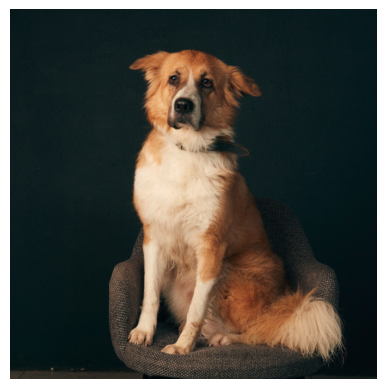

[[ -7.63674927  -7.81394005 -10.83650875  -7.89367676  -7.5188365
   -8.41861629  -7.89541149  -8.86960888  -7.67505789  -9.95176792
   -6.40759039   0.68577111  -9.75337696  -7.57588911  -8.2134428
   -8.74567604  -6.58007288  -6.27431917 -10.36643124 -13.67303181
   -7.89132643 -12.5462265    2.10016727 -10.95241165  -8.04594135
   -7.84959412 -11.55685425  -4.69382954  -2.26446843 -10.09759331
   -8.39836597  -7.37102175 -10.308424    -8.29373646  -7.83685589
   -9.95708656  -6.72490883  -7.38997841  -9.27176666  -9.40874195
  -10.98117924 -11.08720779  -7.55082083  -8.77109337  -6.38092041
   -3.40696883  -9.57337189  -6.51946974  -7.98504877 -11.22881985
  -10.7055769   -7.87449551  -9.02657986  -6.76932049  -8.48092651
   -6.1837225   -7.71464634 -10.16858768  -7.11477089  -9.51397991
   -7.51140308  -2.82753611  -5.94049168  -4.65627861  -1.25967276
   -8.26117325  -9.79383564  -3.92403197 -12.81743813  -8.52787971
  -10.4526844  -10.21242809  -5.80686712  -8.07909775  -9.435097

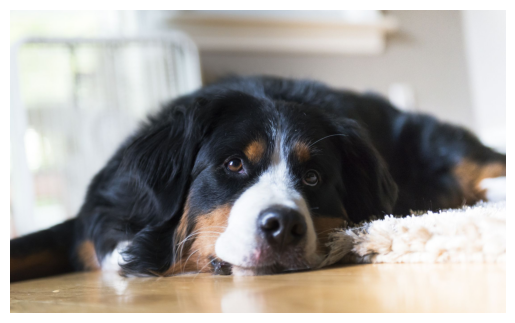

[[-7.90146399 -5.12475586 -6.25286102 -3.63396549 -5.11114645 -7.45391417
  -6.57456398 -5.94556093 -6.18455029 -4.69955254 -3.21500683 -4.01432657
  -2.26771617 -7.25555992 -4.97556448 -7.16805792 -7.40955591 -3.98202085
  -8.73099136 -2.11498475 -5.45636749 -2.21596789 -6.59912968 -8.85617828
  -5.91326189 -7.31432676 -4.55110884 -6.49787998 -6.51745558 -6.26583004
  -6.33802366 -6.69052315 -6.80027246 -6.47841787 -8.1390295  -5.53208208
  -9.42533016 -4.08472157 -5.75365925 -6.16152287 -4.66585827 -5.58548355
  -3.69104242 -3.68172479 -4.04420948 -6.97776127 -6.63336277 -5.4766264
  -7.80159807 -3.80039692 -6.64778137 -8.02877617 -8.22262859 -4.31276417
  -7.93589544 -5.1896553  -8.30073738 -8.06851673 -4.69244909 -4.91078377
  -6.25538588 -6.44481087 -7.28834724 -7.29276085 -6.37854815 -4.94758511
  -4.27422285 -5.81485653 -7.06046104 -6.53656006  2.52168727 -8.35471344
  -6.95983458 -6.27950096 -7.61815786 -4.6864543  -6.95156956 -5.55372953
  -8.81087971 -5.38375616 -5.68085432 -

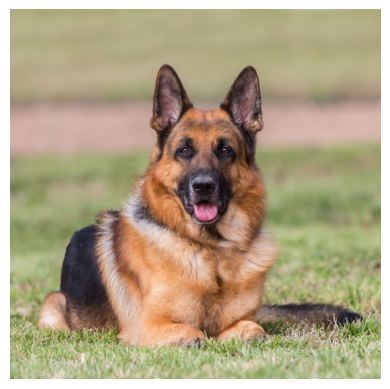

[[ -6.92095613  -4.96261311  -9.61238956   0.30870962  -1.41913867
    2.72103119  -9.34420109  -7.56886387  -6.90097857  -7.05378437
   -6.82808971  -4.62977409  -6.24833202  -8.348279    -8.14756203
   -9.32608128  -7.69974709  -7.08653307  -7.03534555  -8.69488144
   -2.6792388   -4.70783663  -7.46180344  -4.93224525  -9.22245121
   -6.92247486  -9.25048256  -8.08975124  -4.4399929   -7.99470758
   -4.98148203  -7.57035589  -5.86675882  -9.40825367  -9.27795315
   -7.50874376  -8.3224926   -5.36328936  -5.31710052  -7.20911121
   -7.85390377  -5.30612803  -1.98863256  -5.19150209  -6.82224512
   -6.95868874  -8.68157196  -6.06622124  -6.56847048  -6.93595123
   -2.36469054  -7.13833094  -8.96335888  -4.29205275  -8.77505207
   -8.87114716  -6.89303493  -7.28494024  -7.33263206  -7.2000289
   -8.96417141  -5.7452035   -6.72725296  -8.46658325  -7.30974913
   -7.57003498  -2.9803226   -6.20079374  -9.16362858  -7.28965092
   -6.22798061  -9.40313435  -8.0802784   -8.57946205  -5.20907

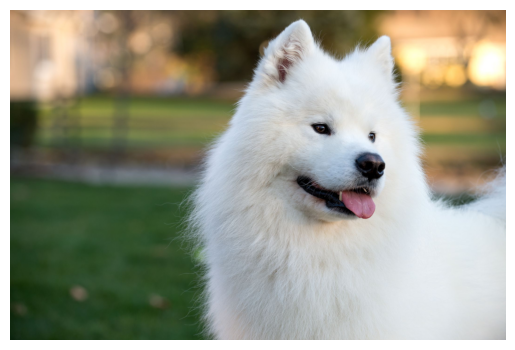

[[-6.75574255 -5.51193285 -7.43072796  0.0323657   2.47123241 -3.0356245
  -5.82515335 -6.31872988 -5.71097326 -4.93065882 -2.77169776 -3.34436512
  -6.67523718 -5.81205034 -6.27798033 -5.13278246 -6.16271544 -5.28655338
  -5.5574646  -6.74773502 -5.05424881 -6.53390789 -5.47051811 -5.18644476
  -6.72834587 -5.72473001 -7.54067421 -5.51422977 -4.50499296 -6.28427315
  -4.90283108 -4.992311   -6.33073759 -8.2256794  -7.09721994 -7.57708788
  -6.50294447 -5.71322584 -4.57051945 -5.66673565 -8.11919689 -6.9177351
  -1.74307895 -5.12813044 -4.45801592 -5.14309359 -6.47357988 -3.53351784
  -6.13431072 -5.97977638 -5.91683817 -6.40058136 -6.29422712 -4.58268166
  -7.15111399 -6.64820337 -4.96760321 -6.51884317 -5.72553253 -5.93707609
  -6.78604174 -3.64346361 -5.58710957 -6.11270475 -4.00821066 -6.51848173
  -3.67289114 -5.37241268 -7.22110605 -6.45201683 -3.36326885 -7.23667574
  -5.70479679 -6.80398321 -5.5732398  -4.96312571 -8.08273125 -4.95600891
  -4.62617445 -4.60206318 -5.51528025 -4

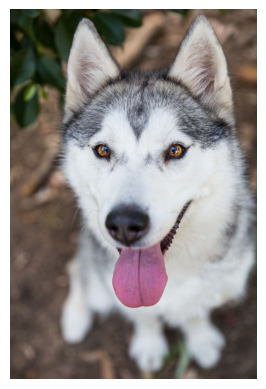

In [10]:
# Prediction arrays
def preprocess_and_predict(img_path, predictor):
    recomp = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])
    
    dog_pil = Image.open(img_path).convert('RGB') 
    image = recomp(dog_pil).unsqueeze(0)
    
    if image.size(1) != 3:
        raise ValueError(f"Unexpected number of channels: {image.size(1)}. Expected 3 channels.")
    
    response = predictor.predict(image.numpy())
    return response, dog_pil

for img_path in image_paths:
    prediction, dog_image = preprocess_and_predict(img_path, predictor)
    print(prediction)
    print(f'length of response: {len(prediction[0])}')
    
    plt.imshow(dog_image)
    plt.axis('off')
    plt.show()


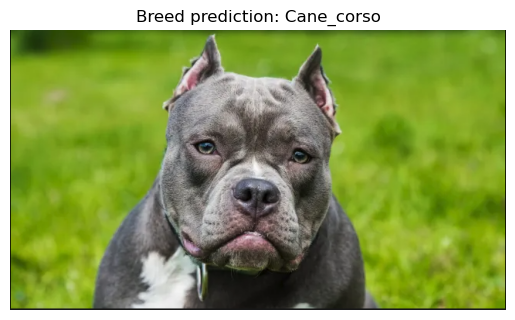

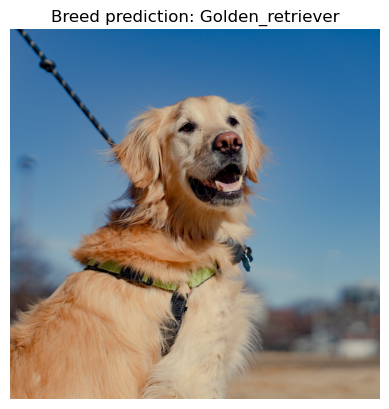

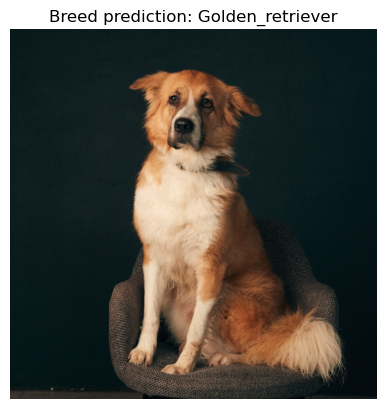

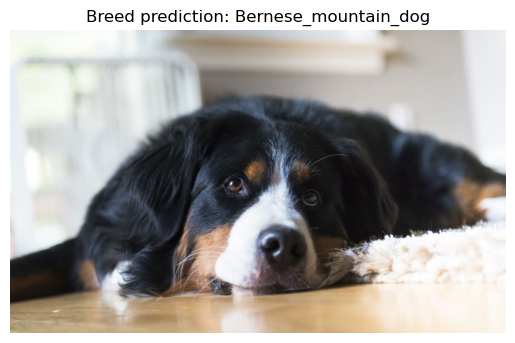

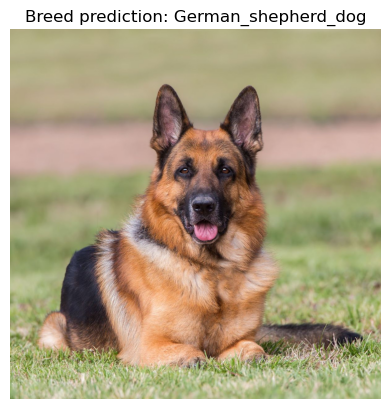

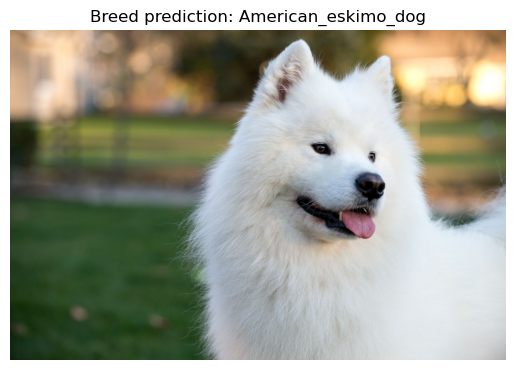

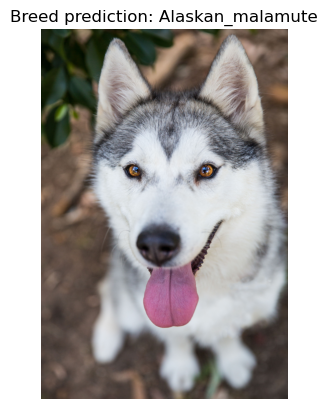

In [19]:
def preprocess_and_predict(img_path, predictor):
    recomp = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])
    
    dog_pil = Image.open(img_path).convert('RGB') 
    image = recomp(dog_pil).unsqueeze(0)
    
    if image.size(1) != 3:
        raise ValueError(f"Unexpected number of channels: {image.size(1)}. Expected 3 channels.")
    
    response = predictor.predict(image.numpy())
    return response, dog_pil

for img_path in image_paths:
    prediction, dog_image = preprocess_and_predict(img_path, predictor)
    
    predicted_index = np.argmax(prediction)
    breeds = list(unique_breeds)
    breeds = sorted(breeds)
    predicted_breed = breeds[predicted_index]
    name_breed = predicted_breed.split('.')[1]
    
    plt.imshow(dog_image)
    plt.title(f"Breed prediction: {name_breed}")
    plt.axis('off')
    
    img_name = os.path.basename(img_path) 
    save_path = os.path.join("results_inference", f"predicted_{name_breed}_{img_name}")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

In [20]:
# Deleting Endpoint
predictor.delete_endpoint()